# Notebook 1: Neural ODE 2D

Este notebook implementa e treina Neural ODEs para aprender transformações em dados 2D.

## Objetivos:
1. Implementar VectorField e NeuralODE
2. Treinar em dataset 2D sintético (moons)
3. Visualizar trajetórias e vector fields
4. Analisar NFEs e comparar solvers


In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import torch
import torch.optim as optim
from src.models.neural_ode import NeuralODE
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, get_dataloader
from src.utils.training import train_neural_ode, count_nfe
from src.utils.visualization import (
    plot_data_distribution,
    plot_trajectories,
    plot_transformation,
    plot_vector_field,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## 1. Carregar Dataset


/home/lucas-barbosa/Downloads/Projetos/flow/notebooks/../src/utils/datasets.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(X, dtype=torch.float32)


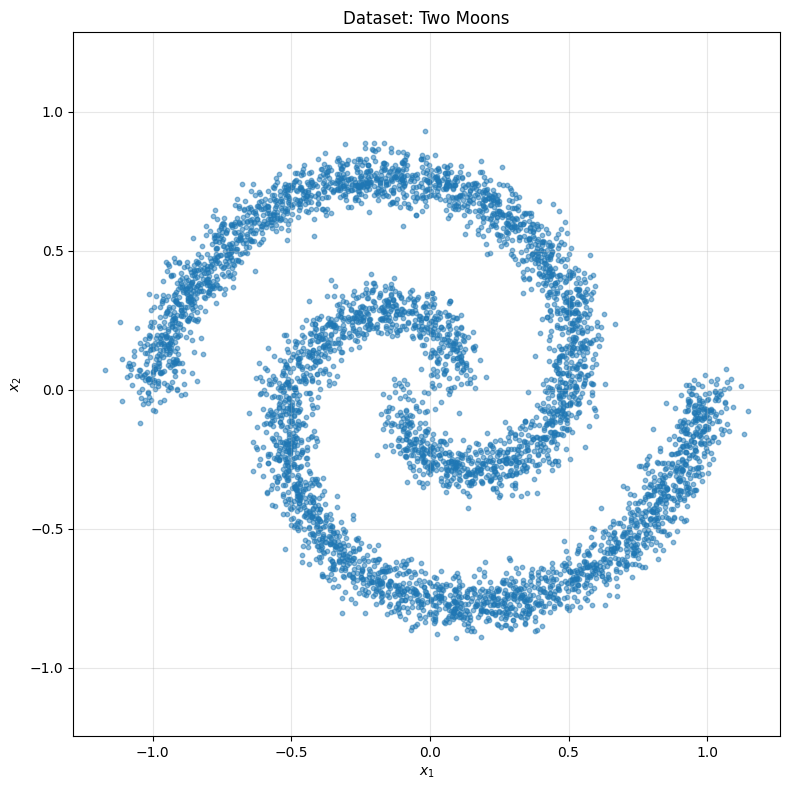

In [2]:
# Criar dataset
dataset = Synthetic2D(n_samples=5000, noise=0.05, dataset_type='spirals')
dataloader = get_dataloader(dataset, batch_size=128, shuffle=True)

# Visualizar dados
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_data_distribution(dataset.data, ax=ax, title="Dataset: Two Moons")
plt.tight_layout()
plt.show()


## 2. Criar e Treinar Modelo


In [ ]:
# Criar modelo
vf = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
model = NeuralODE(vf, solver='dopri5', rtol=1e-3, atol=1e-4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Treinar
train_neural_ode(model, dataloader, optimizer, device, num_epochs=50)


Epoch 1/50:  15%|█▌        | 6/40 [00:00<00:04,  7.54it/s]

## 3. Visualizar Trajetórias


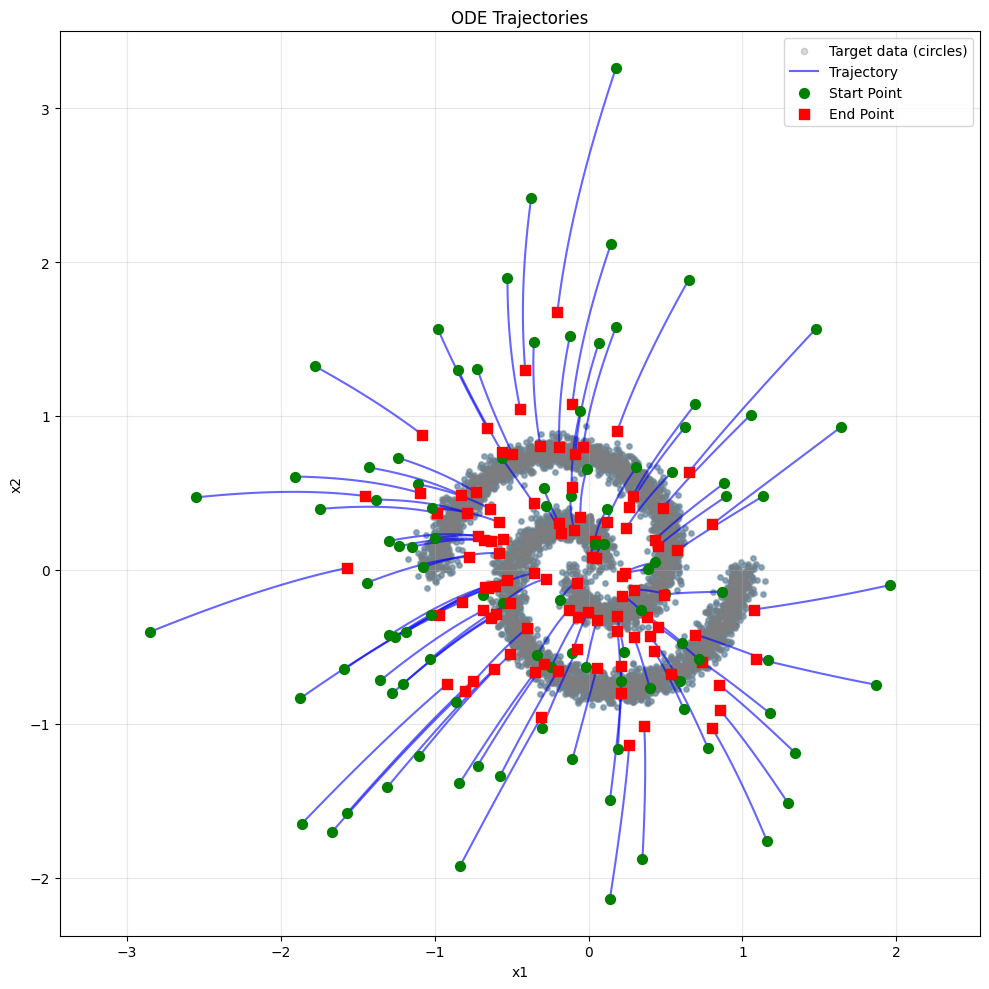

In [15]:
sample_data = torch.randn(100, 2).to(device)
t_span = torch.linspace(0, 1, 100).to(device)

# Plotar trajetórias
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Primeiro, plotar a distribuição alvo (circles) para referência
plot_data_distribution(
    dataset.data,
    ax=ax,
    title="Trajectories and Target Distribution"
)
ax.scatter(
    dataset.data[:, 0].numpy(),
    dataset.data[:, 1].numpy(),
    alpha=0.3,
    s=20,
    color='gray',
    label='Target data (circles)',
    zorder=1
)

# Depois, plotar as trajetórias
plot_trajectories(model, sample_data, t_span=t_span, ax=ax)
plt.tight_layout()
plt.show()


## 4. Visualizar Vector Field


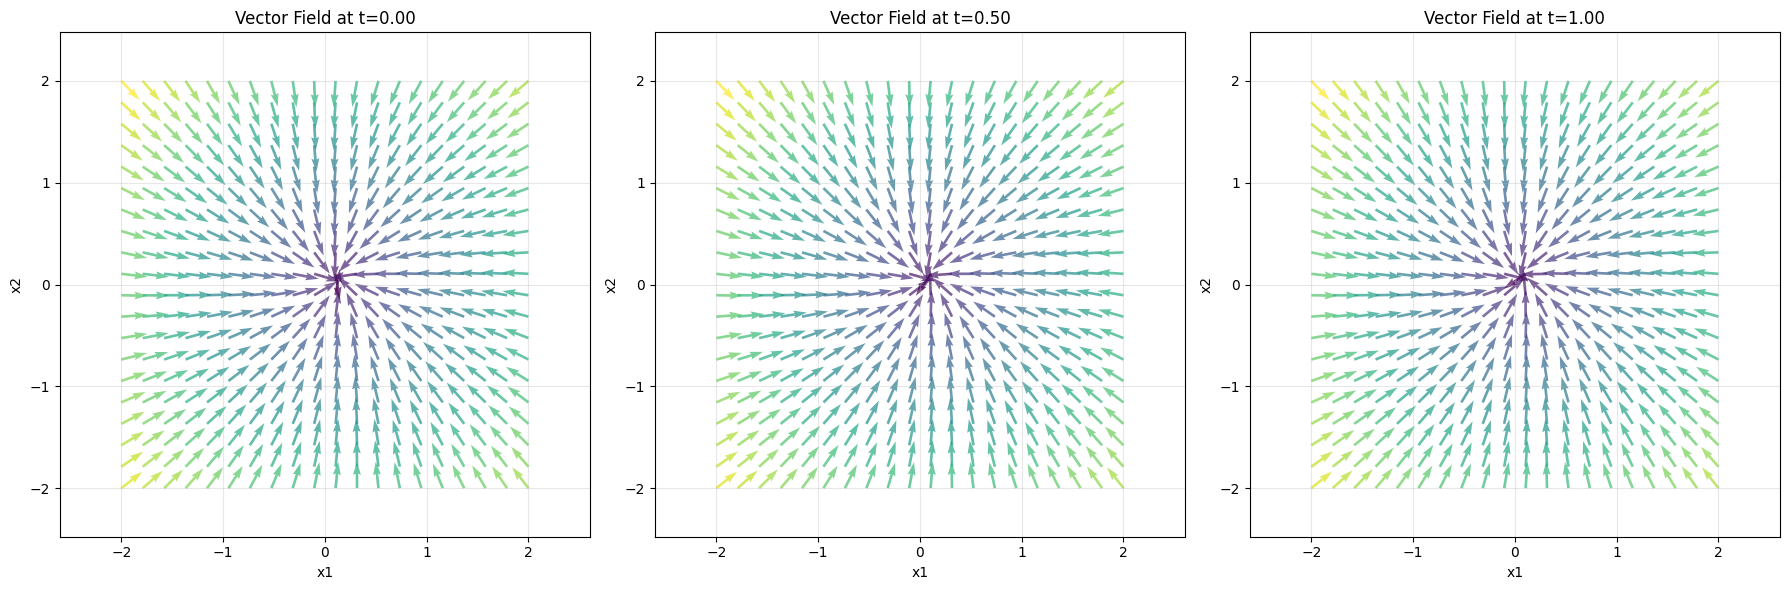

In [9]:
# Plotar vector field em diferentes tempos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    plot_vector_field(
        model,
        xlim=(-2, 2),
        ylim=(-2, 2),
        n_grid=20,
        t=t,
        ax=axes[i]
    )
plt.tight_layout()
plt.show()


## 5. Visualizar Transformação


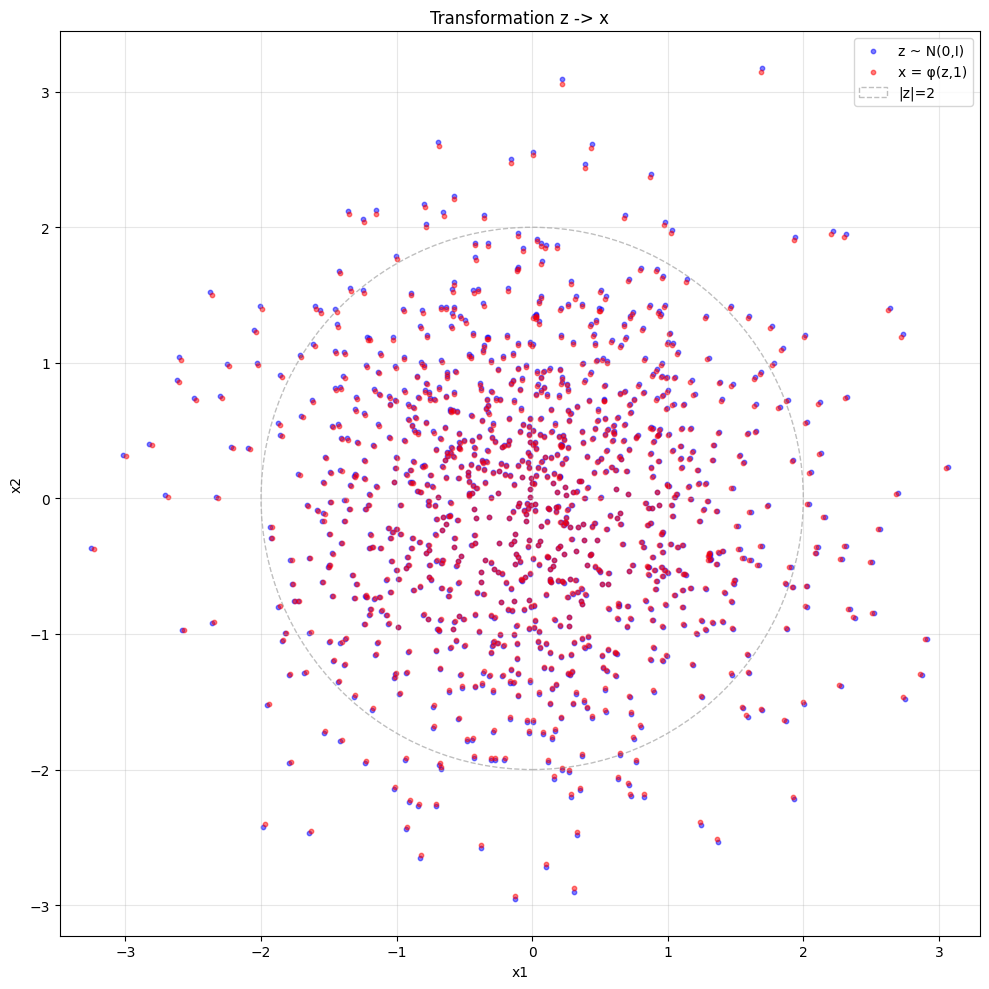

In [6]:
# Plotar transformação z ~ N(0,I) -> x
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_transformation(model, n_samples=1000, ax=ax)
plt.tight_layout()
plt.show()


## 6. Analisar NFEs (Number of Function Evaluations)


In [7]:
# Comparar diferentes solvers
solvers = ['euler', 'rk4', 'dopri5']
nfe_results = {}

# Usar amostras de N(0, I) para contagem de NFEs
sample_batch = torch.randn(10, 2).to(device)

for solver in solvers:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(vf_test, solver=solver, rtol=1e-3, atol=1e-4).to(device)
    model_test.load_state_dict(model.state_dict())  # Usar mesmos pesos

    nfe = count_nfe(model_test, sample_batch)
    nfe_results[solver] = nfe
    print(f"{solver}: {nfe} NFEs")

# Comparar diferentes tolerâncias
tolerances = [(1e-2, 1e-3), (1e-3, 1e-4), (1e-4, 1e-5)]
nfe_tol_results = {}

for rtol, atol in tolerances:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(vf_test, solver='dopri5', rtol=rtol, atol=atol).to(device)
    model_test.load_state_dict(model.state_dict())

    nfe = count_nfe(model_test, sample_batch)
    nfe_tol_results[(rtol, atol)] = nfe
    print(f"rtol={rtol}, atol={atol}: {nfe} NFEs")


euler: 1 NFEs
rk4: 4 NFEs
dopri5: 14 NFEs
rtol=0.01, atol=0.001: 14 NFEs
rtol=0.001, atol=0.0001: 14 NFEs
rtol=0.0001, atol=1e-05: 14 NFEs
